In [2]:
import open3d as o3d
import numpy as np

from Eval.Mesh import CreatePointcloudFromMeshVertices, CreatePointcloudFromDir
from Eval.Clouds.Sphere import CreateBaseSpherePointCloud
from Eval.Error import CalculateRMSE
from Eval.Plotting import plot_technique_rmse
from Utils.Data import saveJSON, loadJSON
from Utils.Viz import VizualiseBaseTargetPointclouds

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Create Base Clouds for Comparison, Created Programatically for High Accuracy.

# Diameter of Base IRL Sphere: 200mm
baseSphere = CreateBaseSpherePointCloud(diameter = 200 / 1000, resolution=5000)
baseSphere.paint_uniform_color([0.5, 0.5, 0.5])


PointCloud with 5000 points.

In [4]:
# Get the Obtained Data Clouds for Comparison, on the Base Programatically Created Clouds.

eval = 'PolyCam'

evalDataDir = f'../data/{eval}/sphere.ply'

#collectedSphere = CreateBaseSpherePointCloud(diameter = 1.34, resolution=3000) # Temp For RMSE Collection Testing
collectedSphere = CreatePointcloudFromDir(evalDataDir)
collectedSphere.paint_uniform_color([1, 0, 0])

PointCloud with 367800 points.

In [5]:
# Perform ICP Registration to Obtain a Transformation Matrix
# This allows for more accurate comparison of the clouds, by making them similar positioning.


icpRegResults = o3d.pipelines.registration.registration_icp(baseSphere, 
                                                            collectedSphere, 
                                                            0.1, 
                                                            np.identity(4), 
                                                            o3d.pipelines.registration.TransformationEstimationPointToPoint(), 
                                                            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(icpRegResults)

# Apply the Transformation Matrix to the Obtained Data Clouds
baseSphere.transform(icpRegResults.transformation)

RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.712135e-03, and correspondence_set size of 5000
Access transformation to get result.


PointCloud with 5000 points.

In [12]:
# Quick Visualization of both the Obtained Cloud and the Base Cloud.

VizualiseBaseTargetPointclouds(baseSphere, collectedSphere)

In [7]:
# Calculate the RMSE between the two clouds.

rmse = CalculateRMSE(baseSphere, collectedSphere)

# Added * 1000 to convert to mm
print(f'RMSE (mm): {rmse}')

RMSE (mm): 9.712134534343258


In [8]:
# Add the RMSE to the data file.

jsonFileDir = "../data/techniques-rmse-diagram.json"

data = loadJSON(jsonFileDir)

# Update the sphere RMSE value of data's technique.
dataBuff = data[eval]["sphere"]
print(dataBuff)

data[eval]["sphere"].update({
    "rmse": rmse,
    "inlier_rmse": icpRegResults.inlier_rmse * 1000 # Convert to mm
})

saveJSON(jsonFileDir, data)
print(f'RMSE Data: \n{data}')

{'rmse': 9.859317797704762, 'inlier_rmse': 9.859317797704763}
RMSE Data: 
{'Kinect': {'sphere': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}, 'box': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}}, 'Point_e': {'sphere': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}, 'box': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}}, 'PolyCam': {'sphere': {'rmse': 9.712134534343258, 'inlier_rmse': 9.712134534343265}, 'box': {'rmse': 0.17068160383701134, 'inlier_rmse': 0.0}}}


RMSE Data: 
{'sphere': [0.17068160383701134, 0.17068160383701134, 9.712134534343258], 'box': [0.17068160383701134, 0.17068160383701134, 0.17068160383701134]}


C:\Users\finnd\AppData\Local\Temp\ipykernel_11288\3083896601.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


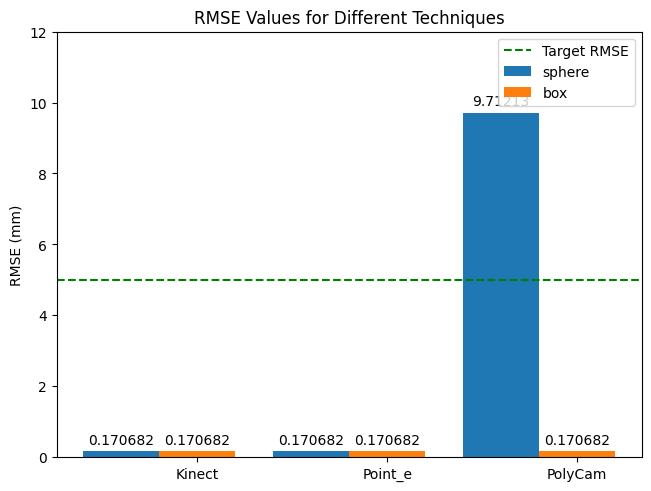

In [9]:
# Create Figure Based on Current Dataset

fig = plot_technique_rmse(data, upper_lim=12) # 1.2cm

fig.show()

In [10]:
# Save Figure

fig.savefig("../data/techniques-rmse-diagram.png", format="png", dpi=300)